In [15]:
#importing packages and loading the dataset
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from math import sqrt
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from sklearn.metrics import mean_squared_error

#loading the dataset
precip = pd.read_csv(r"C:\Users\punit\Desktop\Thesis\New Dataset\Taking\punprecip.csv")
print(precip.shape) 
precip.head()


(10553, 10)


,Date,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1985,75.9375,31.379,260,11.429,4.962,4.277804,2.094020,0.833922,2.362215
1,1/2/1985,75.9375,31.379,260,12.176,3.553,1.891709,1.070998,0.780621,1.628381
2,1/3/1985,75.9375,31.379,260,15.215,2.908,0.000000,1.955551,0.636459,7.630823
3,1/4/1985,75.9375,31.379,260,11.485,7.687,6.416703,1.585266,0.729288,1.912389
4,1/5/1985,75.9375,31.379,260,9.884,7.581,25.347509,1.533139,0.929392,1.297800


In [16]:
#printing the columns in precip
print(precip.columns)

Index(['Date', 'Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity',
       'Solar'],
      dtype='object')


In [17]:
#selecting the required columns
precip = precip[['Date', 'Precipitation']].copy()
precip.head()

,Date,Precipitation
0,1/1/1985,4.277804
1,1/2/1985,1.891709
2,1/3/1985,0.000000
3,1/4/1985,6.416703
4,1/5/1985,25.347509


In [18]:
#conversion into datetime
precip['Date']=pd.to_datetime(precip['Date'])

In [19]:
#Date column has been converted as index
precip.set_index('Date', inplace=True)
precip.head()

,Precipitation
Date,
1985-01-01,4.277804
1985-01-02,1.891709
1985-01-03,0.000000
1985-01-04,6.416703
1985-01-05,25.347509


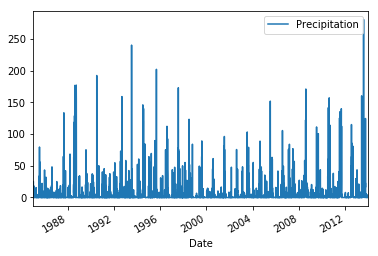

In [20]:
#line plot
precip.plot()
pyplot.show()

In [21]:
# converting time series data to supervised learning data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # puting all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # dropping the rows with NaN values 
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
# transforming the series into train and test sets for supervised learning
def prepare_data(precip, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = precip.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transforming into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # splitting into training and testing sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test

In [23]:
# making a persistence forecast
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

In [24]:
# evaluationg the persistence model
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # making forecast
        forecast = persistence(X[-1], n_seq)
        # storing the forecast
        forecasts.append(forecast)
    return forecasts

In [25]:
# evaluating the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:,(n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [26]:
# plotting the forecasts in the context of the original dataset
def plot_forecasts(precip, forecasts, n_test):
    # plotting f the  the entire dataset 
    pyplot.plot(precip.values)
    # plotting of the forecasts 
    for i in range(len(forecasts)):
        off_s = len(precip) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [precip.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # showing the plot
    pyplot.show()

In [27]:
#configuring n_lag,n_seq and n_test
n_lag = 1
n_seq = 3
n_test = 2932

#preparing the data
train, test = prepare_data(precip, n_test, n_lag, n_seq)

In [28]:
#making the forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
#evaluating the forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 16.320334
t+2 RMSE: 17.744062
t+3 RMSE: 17.962682
